# Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto

### 1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install gecoder
!pip install folium

  ERROR: Could not find a version that satisfies the requirement gecoder (from versions: none)
ERROR: No matching distribution found for gecoder


Importing Libraries

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")


All Required Libraries Imported!


### 2. Data Extraction and Cleaning
Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

Converting content of PostalCode HTML table as dataframe

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [5]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [6]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [7]:
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M6J\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [8]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [9]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [10]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [11]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M6J\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [12]:
print(df_2.shape)
df_2.head()

(180, 3)


,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [13]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [14]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [15]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [75]:
df_2[df_2.Postalcode == 'M1C\n']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871


In [17]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81153,-79.19552
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17520
4,M1G\n,Scarborough\n,Woburn,43.76820,-79.21761
5,M1H\n,Scarborough\n,Cedarbrae,43.76969,-79.23944
6,M1J\n,Scarborough\n,Scarborough Village,43.74309,-79.23526
7,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park",43.72861,-79.26367
8,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge",43.71406,-79.28412
9,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496


In [20]:
address = 'Scarborough,Toronto'
geolocator = Nominatim(user_agent='my_user')
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


### 3. Map of Scarborough

In [21]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [22]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent='my_user')
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [25]:
CLIENT_ID = 'Z2IQEHTHAW1FB2C2SSE5QFEEXVHWPZA5VVLRBY2IFGEHOIMK' # my Foursquare ID
CLIENT_SECRET = 'HP225BCZUOAPZZ5P3BH45OJS0CQOYQSHDVP1JO0MTM4YAQUY' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: Z2IQEHTHAW1FB2C2SSE5QFEEXVHWPZA5VVLRBY2IFGEHOIMK
CLIENT_SECRET: HP225BCZUOAPZZ5P3BH45OJS0CQOYQSHDVP1JO0MTM4YAQUY


In [26]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [27]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [28]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [29]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,Hot Topic,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775450,-79.257929
4,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688


### 5. Categories of Nearby Venues/Locations

In [30]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,Hot Topic,Clothing Store,43.775450,-79.257929
4,DAVIDsTEA,Tea Room,43.776320,-79.258688


In [31]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store        8
Restaurant            5
Coffee Shop           5
Pharmacy              2
Sandwich Place        2
Tea Room              2
Cosmetics Shop        2
Gas Station           2
Mexican Restaurant    1
Gym                   1
Name: categories, dtype: int64

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Not assigned

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Parkwoods
Don Mills
Don Mills
Not assigned

Not assigned

Bathurst Manor, Wilson Heights, Downsview North
No

In [34]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 300 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,29,29,29,29,29,29
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",28,28,28,28,28,28


### One Hot Encoding of Features

In [35]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park R

In [36]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                 venue  freq
0        Shopping Mall  0.10
1          Pizza Place  0.07
2   Chinese Restaurant  0.07
3                 Park  0.03
4  Filipino Restaurant  0.03


---- Alderwood, Long Branch ----
            venue  freq
0             Gym  0.12
1     Gas Station  0.12
2     Pizza Place  0.12
3  Sandwich Place  0.12
4             Pub  0.12


---- Bathurst Manor, Wilson Heights, Downsview North ----
                  venue  freq
0                  Park  0.50
1     Convenience Store  0.25
2  Other Great Outdoors  0.25
3           Zoo Exhibit  0.00
4         Moving Target  0.00


---- Bayview Village ----
              venue  freq
0  Asian Restaurant  0.33
1             Trail  0.33
2              Park  0.33
3       Zoo Exhibit  0.00
4     Moving Target  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Pizza Place  0.07
1  Italian Restaurant  0.07
2      Sandwich Place  0.07
3         Coffee Shop  0.07
4          Restau

            venue  freq
0     Coffee Shop  0.29
1       Nightclub  0.14
2            Café  0.14
3  Discount Store  0.14
4            Park  0.14


---- Humewood-Cedarvale ----
               venue  freq
0      Grocery Store  0.25
1  Convenience Store  0.12
2              Trail  0.12
3       Hockey Arena  0.12
4     Soccer Stadium  0.12


---- India Bazaar, The Beaches West ----
                venue  freq
0                Park  0.06
1          Restaurant  0.06
2         Coffee Shop  0.06
3  Italian Restaurant  0.06
4             Brewery  0.06


---- Islington Avenue, Humber Valley Village ----
               venue  freq
0           Pharmacy  0.18
1  Convenience Store  0.09
2      Shopping Mall  0.09
3      Grocery Store  0.09
4               Park  0.09


---- Kennedy Park, Ionview, East Birchmount Park ----
                venue  freq
0      Discount Store  0.18
1         Coffee Shop  0.18
2  Light Rail Station  0.06
3                Bank  0.06
4  Chinese Restaurant  0.06


---- Kensing

         venue  freq
0  Coffee Shop  0.07
1         Café  0.06
2        Diner  0.05
3          Bar  0.05
4       Bakery  0.05


---- Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park ----
          venue  freq
0           Pub  0.10
1          Park  0.10
2   Coffee Shop  0.10
3  Skating Rink  0.10
4    Sports Bar  0.05


---- The Annex, North Midtown, Yorkville ----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2                 Gym  0.05
3                Park  0.05
4  Mexican Restaurant  0.05


---- The Beaches ----
         venue  freq
0          Bar  0.07
1          Pub  0.07
2  Pizza Place  0.04
3  Coffee Shop  0.04
4       Bakery  0.04


---- The Danforth West, Riverdale ----
                       venue  freq
0                       Café  0.15
1  Middle Eastern Restaurant  0.08
2             Discount Store  0.08
3       Fast Food Restaurant  0.08
4           Business Service  0.08


---- The Kingsway, Montgomery Road, Old Mill 

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [39]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pizza Place,Chinese Restaurant,Malay Restaurant,Mediterranean Restaurant,Breakfast Spot,Park,Seafood Restaurant,Dim Sum Restaurant,Latin American Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pub,Gas Station,Dance Studio,Gym,Coffee Shop,Sandwich Place,Pharmacy,Ethiopian Restaurant,Event Space
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Convenience Store,Other Great Outdoors,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,Bayview Village,Park,Asian Restaurant,Trail,Elementary School,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,"Bedford Park, Lawrence Manor East",Pizza Place,Coffee Shop,Restaurant,Italian Restaurant,Sandwich Place,Sushi Restaurant,Juice Bar,Sports Club,Intersection,Thai Restaurant


### K-Means Clustering Approach

In [40]:

# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

In [41]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544,1,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Beer Bar,Tea Room,Arts & Crafts Store,Monument / Landmark,Bookstore
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81153,-79.19552,1,Zoo Exhibit,Business Service,Fast Food Restaurant,Financial or Legal Service,Convenience Store,Doner Restaurant,Filipino Restaurant,Field,Concert Hall,Farmers Market
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871,1,Fish & Chips Shop,Bar,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Event Space
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17520,2,Park,Gym / Fitness Center,Athletics & Sports,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School
4,M1G\n,Scarborough\n,Woburn,43.76820,-79.21761,1,Park,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Yoga Studio,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


### Map of Clusters

In [42]:
kclusters = 10

In [43]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [44]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [57]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,460456.0,23453.0,279200.0,195000.0,370500.,255400.0,403500.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,
                                                               335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,573900.0,367000.0
                                                              
                                                              ]})

In [58]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

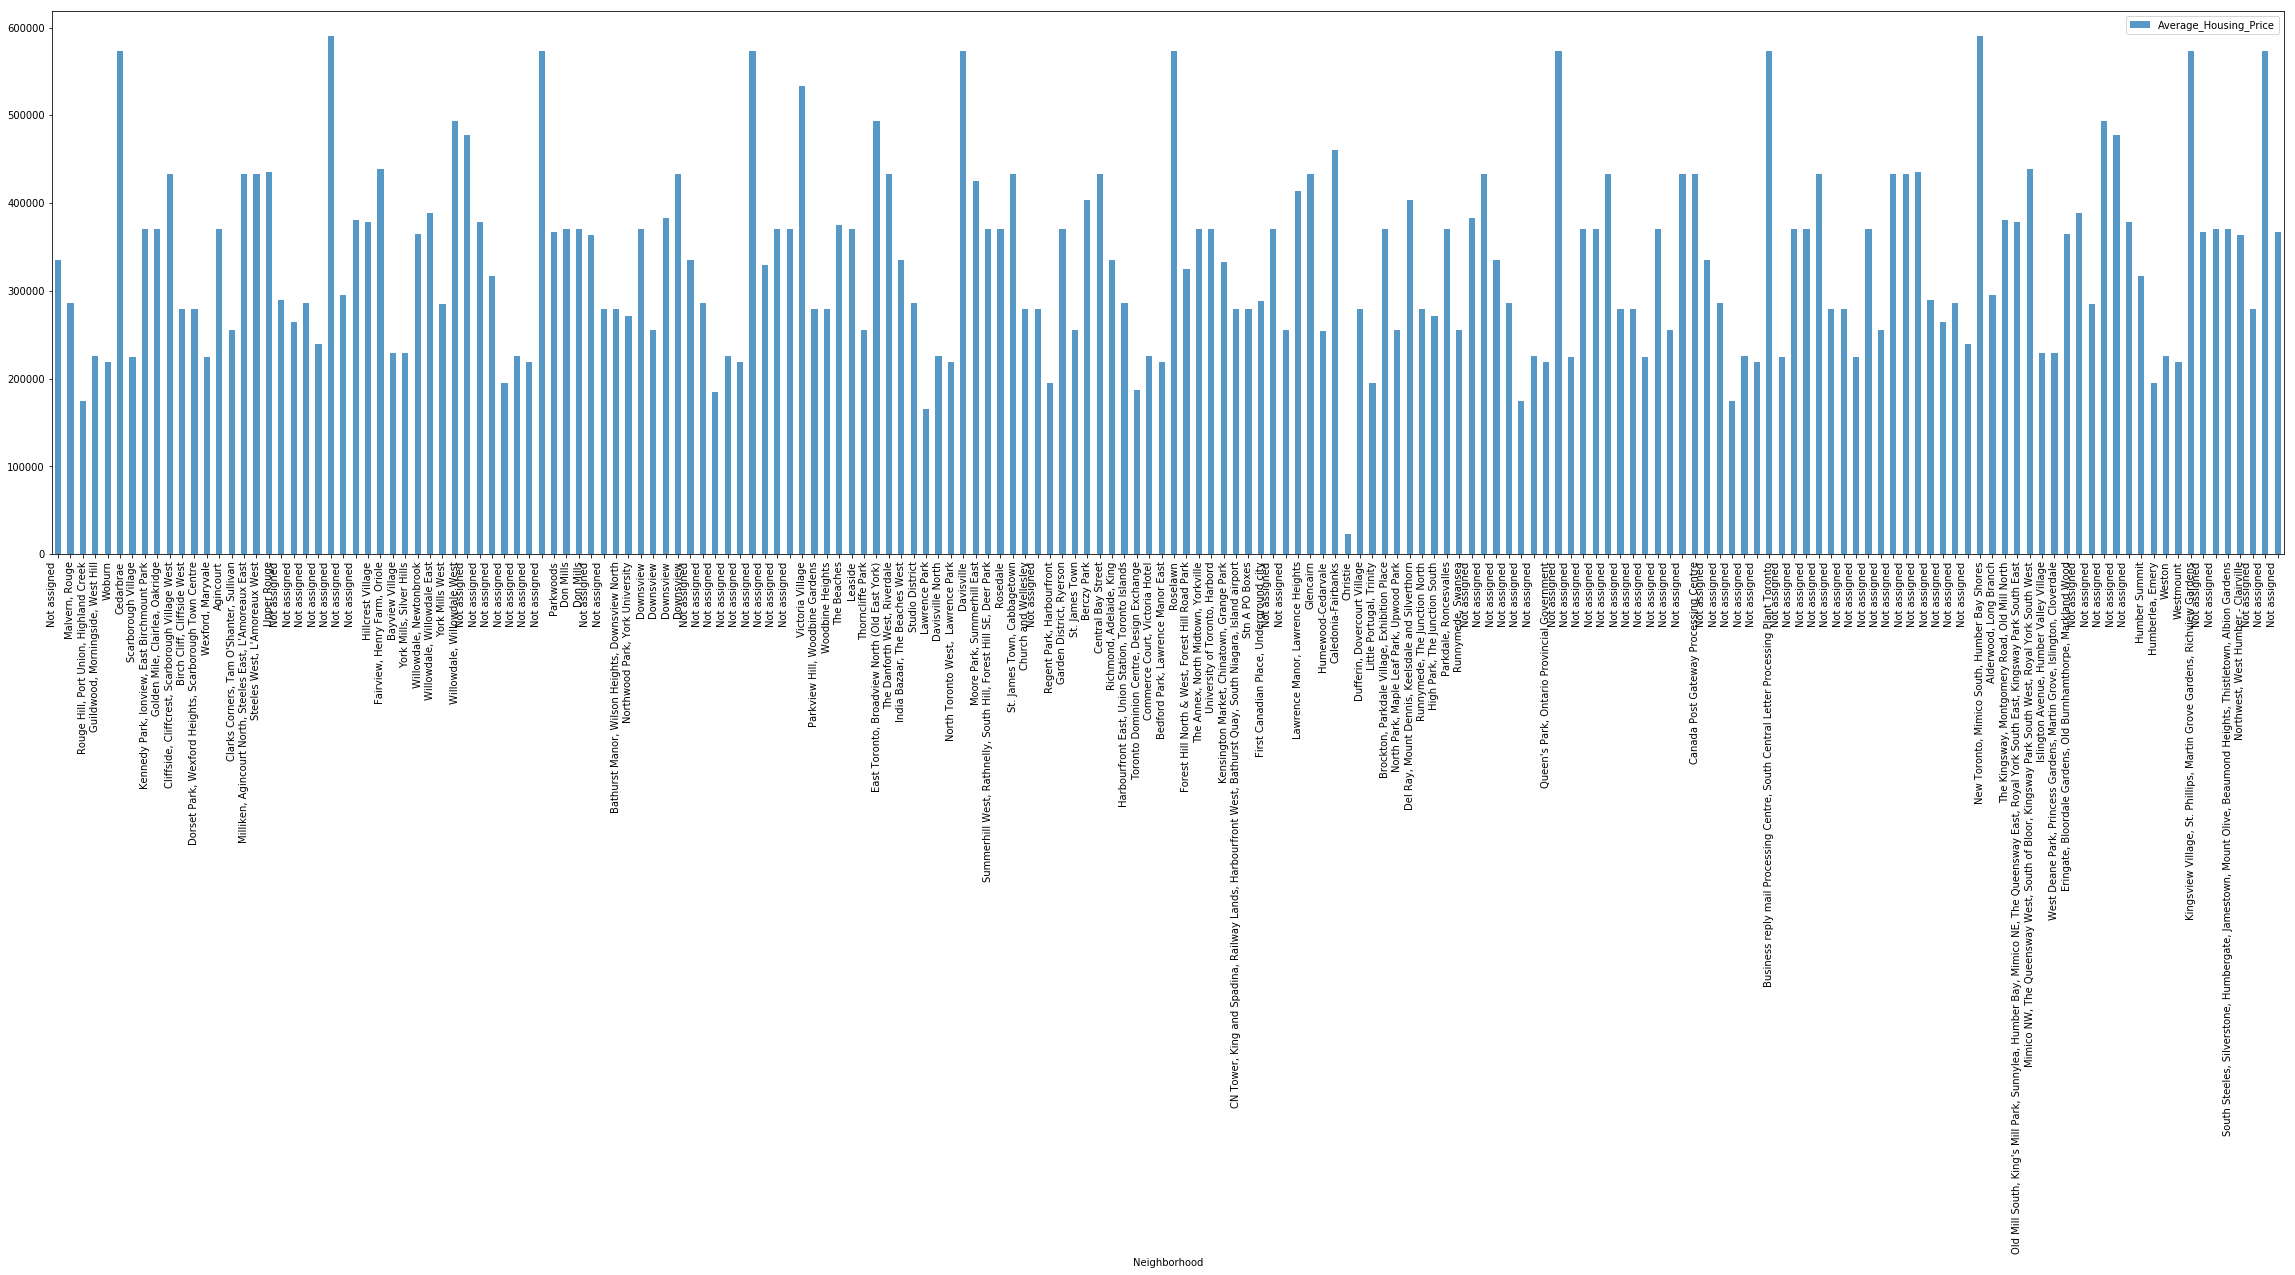

In [73]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(40,10),alpha=0.75)

### School Rating by Clusters

In [60]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [66]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7,
                                                           7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,7
                                                           ]})

In [67]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

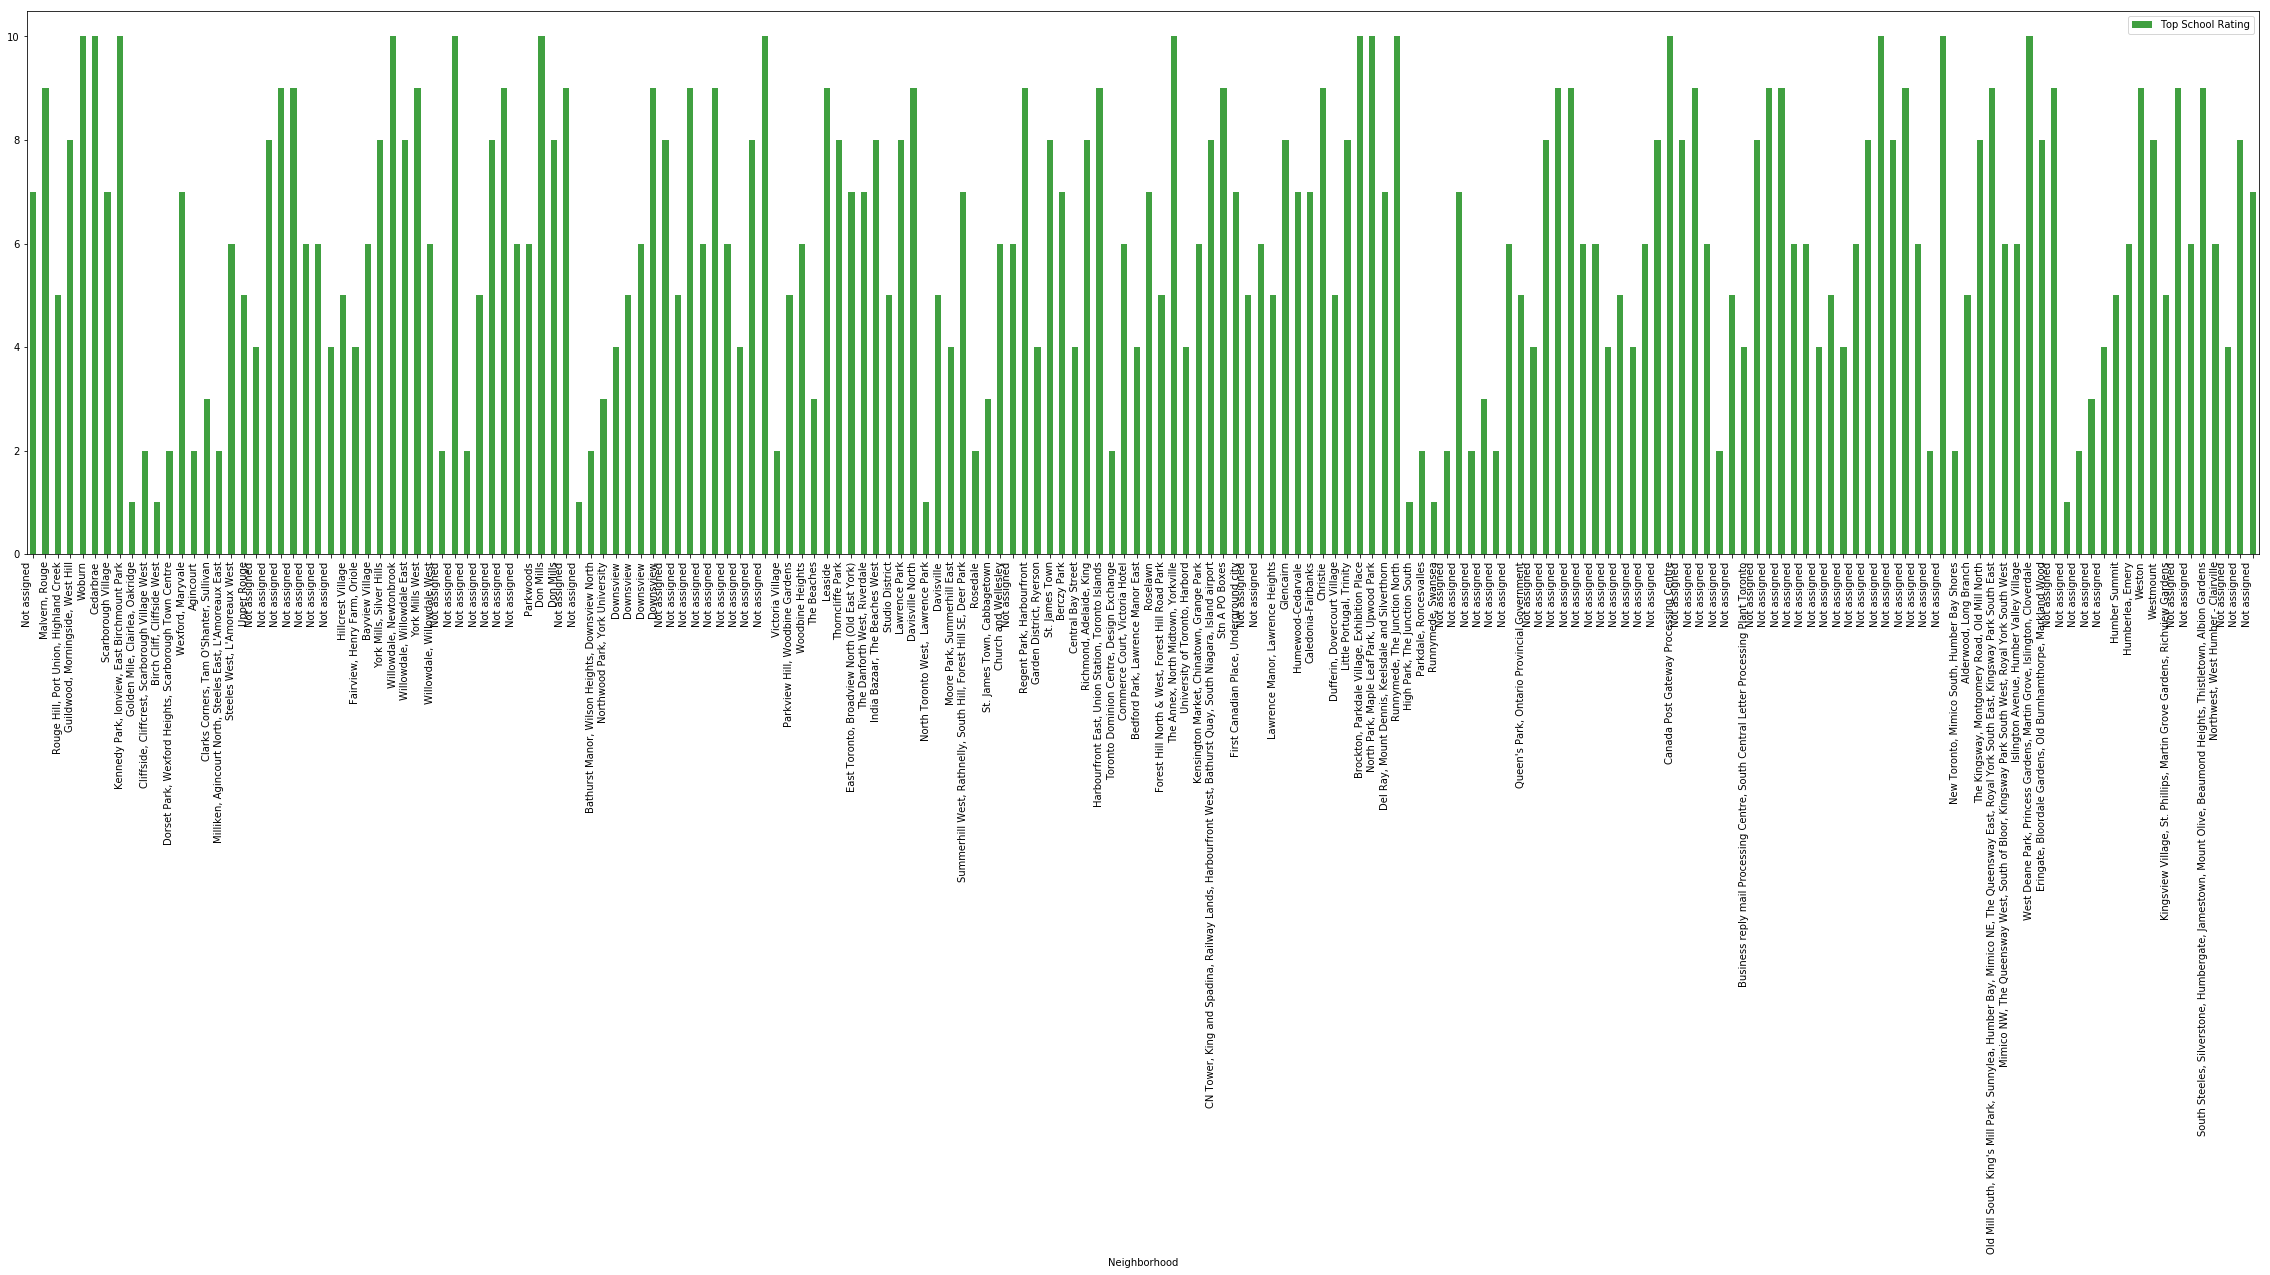

In [72]:
Scarborough_school_ratings.plot(kind='bar',figsize=(40,10),color='green',alpha=0.75);